# Exercise 7: Periodogram and ACF Estimation

In [1]:
import numpy as np
import scipy.signal as signal
import scipy.linalg as linalg
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

figsize_single = (15, 7)
figsize_triple = (15, 21)

In [2]:
%matplotlib inline

In [3]:
def plot_psd(spectrum, name):
    plt.plot(np.arange(len(spectrum)), spectrum, lw=2, color='C0')
    plt.xlim([0, len(spectrum)])
    plt.ylim([0, 1.1*max(spectrum)])
    plt.xlabel(r'$k$', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(name, fontsize=20)
    plt.grid(True)

In [4]:
def psd_from_transfer_function(b, a, signal_length):
    return (np.abs(np.fft.fft(b, signal_length))**2  
            / np.abs(np.fft.fft(a, signal_length))**2)     #PSD = (|transfer_function(w)|)^2

## Task 7.6:
Create two noise processes of length $M = 2^{12}$ by filtering unit-variance AWG noise with

\begin{align}
    &H_1(z) = \frac{1}{1 + 0.8 z^{-1}} \\
    \text{and}& \\
    &H_2(z) = \frac{1}{1 + 0.36 z^{-1} - 0.13 z^{-2} + 0.26 z^{-3} - 0.05 z^{-4} - 0.33 z^{-5} - 0.3 z^{-6}}
\end{align}

respectively, and plot the "true" power-spectral density for each case.

In [5]:
signal_length = 2**12 # Create two noise processes of length M = 2^12

b1 = [1]  # REPLACE b1 = # TODO # numerator of TF1
a1 = [1, 0.8]  # REPLACE a1 = # TODO # Denominator of TF1

b2 = [1]  # REPLACE b2 = # TODO # numerator of TF2
a2 = [1, 0.36, -0.13, 0.26, -0.05, -0.33, -0.3]  # REPLACE a2 = # TODO # Denominator of TF2

x = np.random.randn(signal_length)

y1, y2 = [signal.lfilter(b_i, a_i, x)    # 2 REPLACE y1, y2 = # TODO
          for b_i, a_i in zip([b1, b2], [a1, a2])]


# use function defined above as discussed in theoretical part
S1, S2 = [psd_from_transfer_function(b_i, a_i, signal_length) # 2 REPLACE S1, S2 = # TODO 
          for b_i, a_i in zip([b1, b2], [a1, a2])]

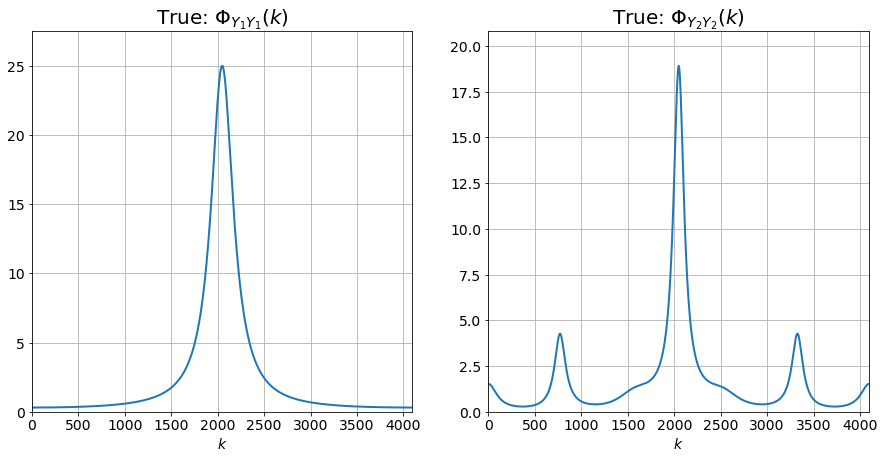

In [6]:
plt.figure(figsize=figsize_single)

plt.subplot(1, 2, 1)
plot_psd(S1, r'True: $\Phi_{Y_1Y_1}(k)$')
plt.subplot(1, 2, 2)
plot_psd(S2, r'True: $\Phi_{Y_2Y_2}(k)$')

## Task 7.7
Calculate the periodograms for both processes with different window lengths.

In [11]:
def periodogram(x, block_length):
    return np.abs(np.fft.fft(x, 2*block_length))**2/block_length # REPLACE return # TODO

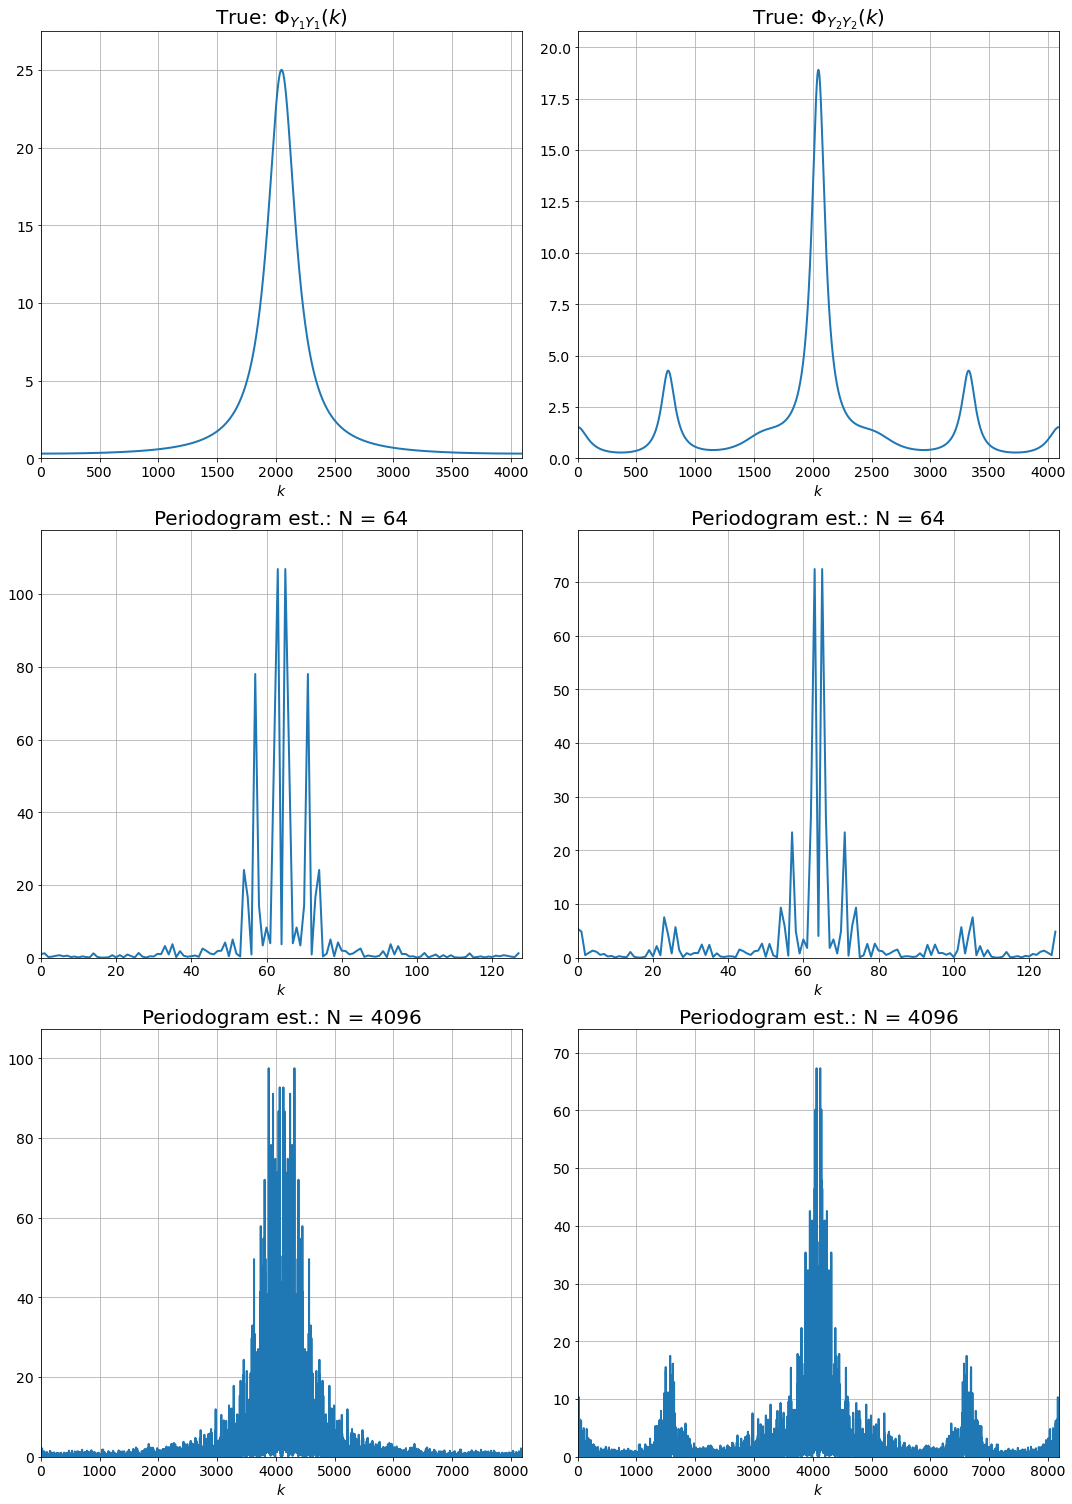

In [12]:
plt.figure(figsize=figsize_triple)

plt.subplot(3, 2, 1)
plot_psd(S1, r'True: $\Phi_{Y_1Y_1}(k)$')
plt.subplot(3, 2, 2)
plot_psd(S2, r'True: $\Phi_{Y_2Y_2}(k)$')

subplot_idx = 3
for fft_length in [64, signal_length]:
    for in_signal in [y1, y2]:
        psd_est = periodogram(in_signal, fft_length)
        plt.subplot(3, 2, subplot_idx)
        plot_psd(psd_est, 'Periodogram est.: N = {}'.format(fft_length))
        plt.tight_layout()
        subplot_idx += 1

## Task 7.7
For both processes, calculate the LPC coefficients for different model orders (2, 6, 10) and plot the estimated PSD.

## Task 7.8:
Now use the Bartlett and Welch methods, respectively,  to get improved spectral estimates for both cases.

In [13]:
def welch(x, block_length, block_shift, window_name):
    num_blocks = int(np.ceil((len(x) - (block_length - block_shift))/block_shift))
    pad_len = int(block_shift*(num_blocks - 1) + block_length - len(x))
    x = np.lib.pad(x, (0, pad_len), 'constant', constant_values=(0, 0))
    
    psd_est = np.zeros(2*block_length)
    w = signal.get_window(window_name, block_length)
    for m in range(num_blocks):
        psd_est += periodogram(w * x[m*block_shift:m*block_shift+block_length], block_length)  # REPLACE # TODO
    return psd_est / (num_blocks * (w**2).sum()/block_length)

In [14]:
def bartlett(x, block_length):
    # hint: are Bartlett and Welch method related? - yes, overlap happens in welch's method.
    return welch(x, block_length, block_length, 'boxcar') 

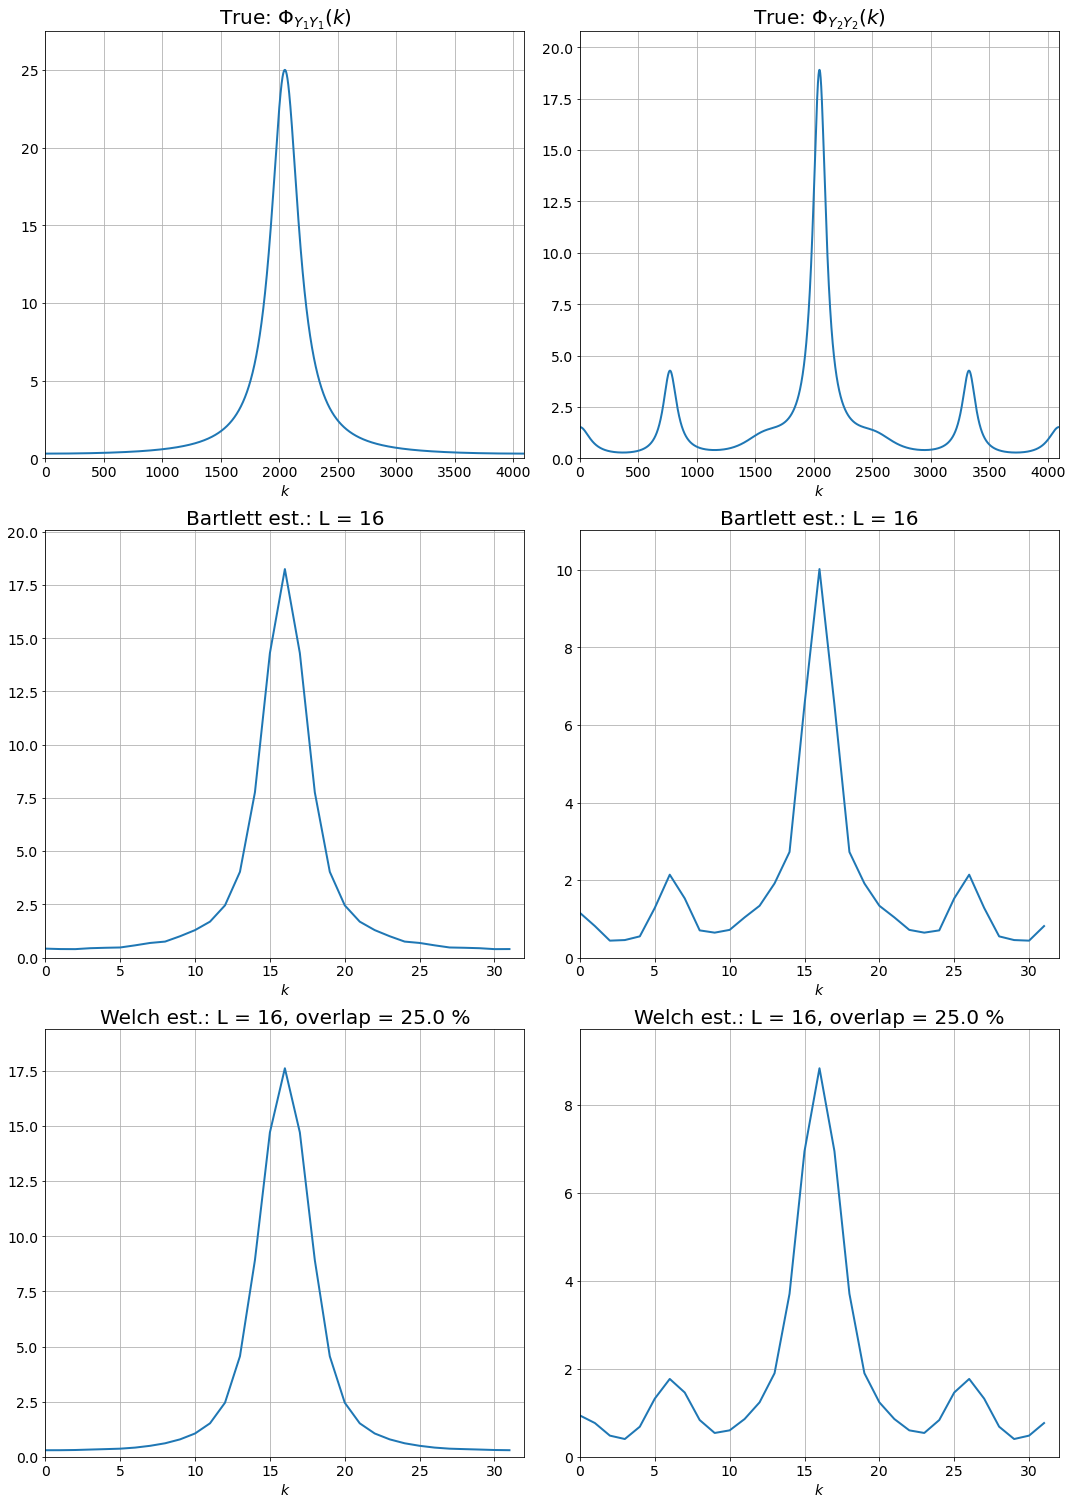

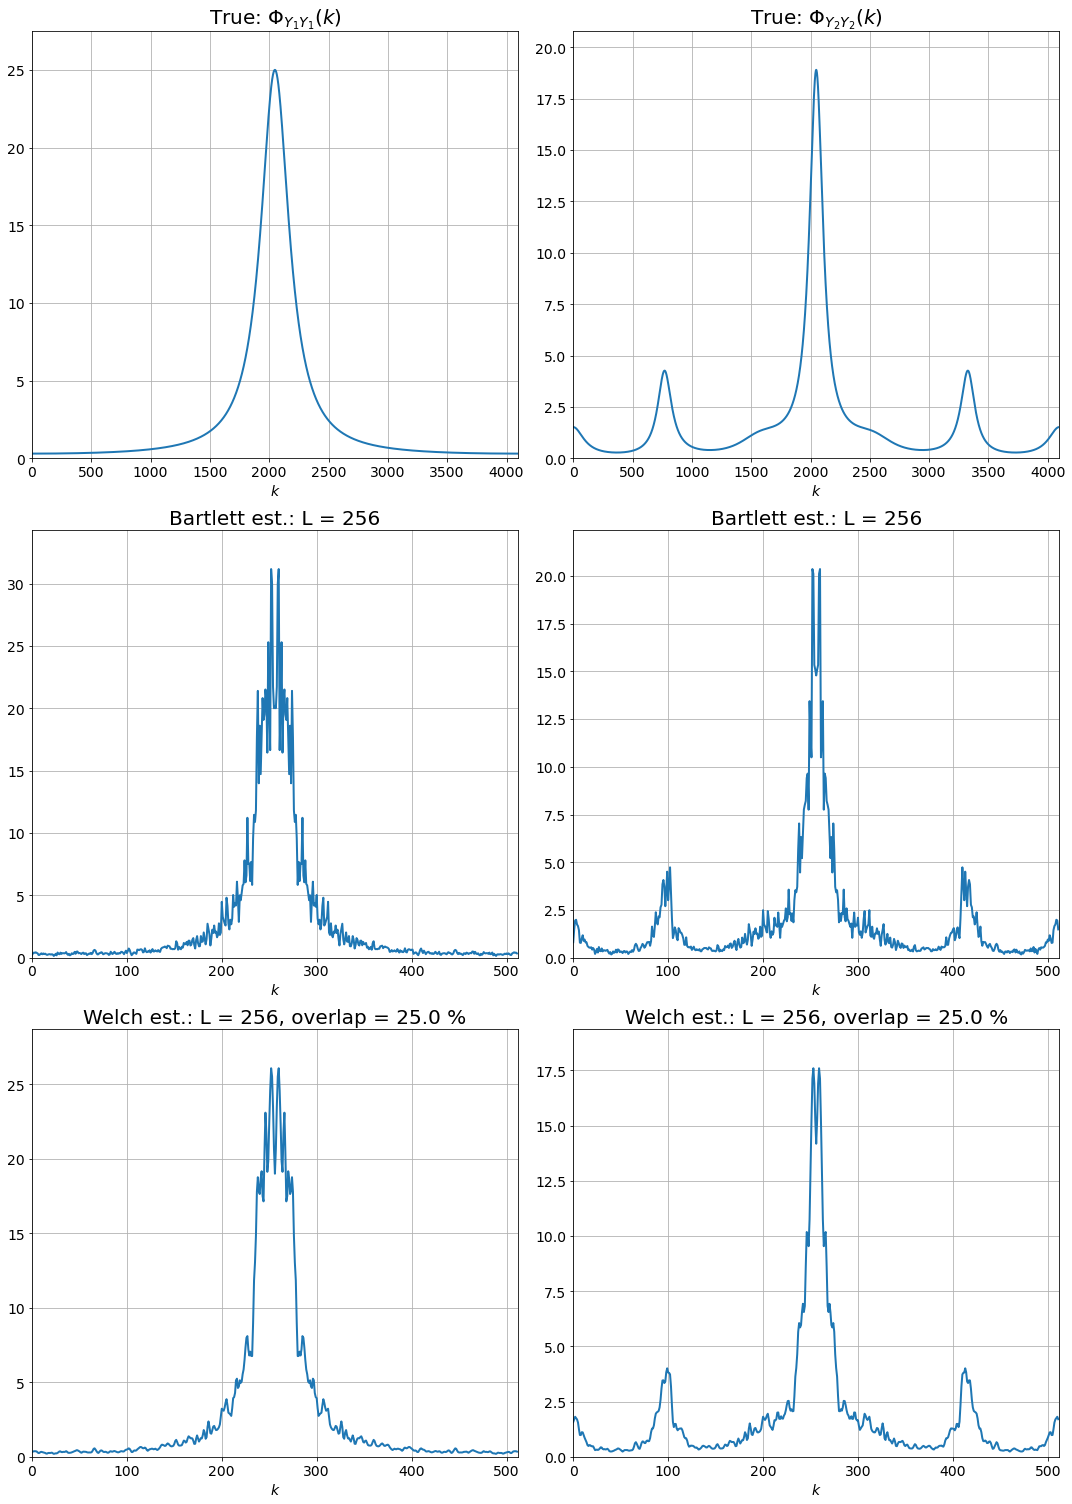

In [15]:
fft_length = signal_length
welch_overlap = 0.25

for L in [16, 256]:
    plt.figure(figsize=figsize_triple)
    plt.title(r'Segment Length $L = $ {L}')

    plt.subplot(3, 2, 1)
    plot_psd(S1, r'True: $\Phi_{Y_1Y_1}(k)$')
    plt.subplot(3, 2, 2)
    plot_psd(S2, r'True: $\Phi_{Y_2Y_2}(k)$')

    subplot_idx = 3
    for in_signal in [y1, y2]:
        block_length = L  
        psd_bartlett = bartlett(in_signal, block_length) 
        plt.subplot(3, 2, subplot_idx)
        plot_psd(psd_bartlett, f'Bartlett est.: L = {L}')
        
        psd_welch = welch(in_signal, block_length, int(welch_overlap*block_length), 'hamming')
        plt.subplot(3, 2, subplot_idx+2)
        plot_psd(psd_welch, f'Welch est.: L = {L}, overlap = {welch_overlap*100} %')
        plt.tight_layout()
        subplot_idx += 1

# Exercise 8: Linear Estimator for Auto-regressive Processes

## Task 8.8

For both cases, calculate the LPC coefficients for different model orders (2, 6, 10) and plot the estimated PSD.

In [16]:
# This function is ready as-is and does not need to be changed
def lpc(s_m, p_order):
    # enforce 1-D array
    s_m = s_m.ravel()
    
    p = p_order + 1

    # calculate autocorrelation
    # and take [r(0), ..., r(P)]
    r_m = np.zeros(p, s_m.dtype)
    nx = np.min([p, len(s_m)])
    
    phi_m = signal.correlate(s_m, s_m)/ len(s_m)
    r_m[:nx] = phi_m[len(s_m)-1:len(s_m) + p_order]
    
    # Solve Ra = -p with Levinson-Durbin.
    # Only the first row of R needs to be passed since
    # it is of Toeplitz structure.
    a = linalg.solve_toeplitz(r_m[:-1], -r_m[1:])
    
    # extend with one to get full filter, ###why are we doing this?
    a = np.concatenate([[1], a])
    
    beta = np.sqrt(a @ r_m) #ch-10, LPC, equation 10.19, maybe gain is calculating here
    return a, beta

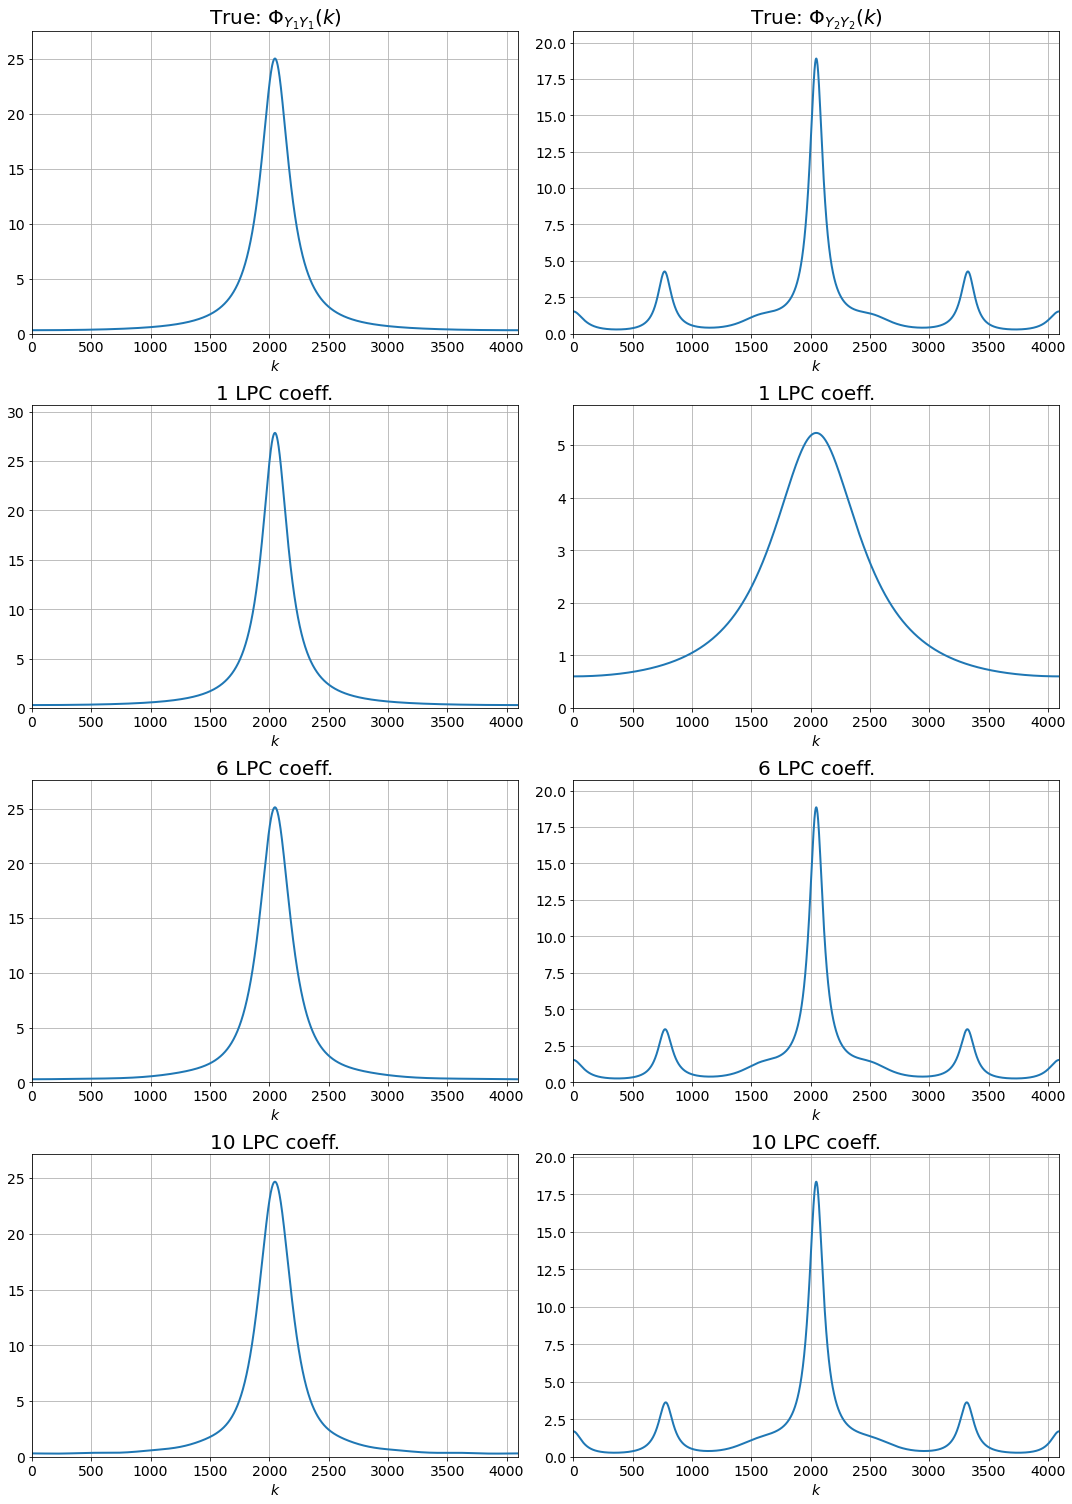

In [17]:
plt.figure(figsize=figsize_triple)

plt.subplot(4, 2, 1)
plot_psd(S1, r'True: $\Phi_{Y_1Y_1}(k)$')
plt.subplot(4, 2, 2)
plot_psd(S2, r'True: $\Phi_{Y_2Y_2}(k)$')
fft_length = signal_length

for lpc_idx, lpc_order in enumerate([1, 6, 10]):
    for sig_idx, in_signal in enumerate([y1, y2]):
        h_lpc, beta = lpc(in_signal, lpc_order)  # REPLACE h_lpc, beta =  # TODO
        psd_est = psd_from_transfer_function([beta], h_lpc, fft_length)  # REPLACE psd_est = # TODO
        
        plt.subplot(4, 2, 3 + 2*lpc_idx + sig_idx)
        plot_psd(psd_est, '{} LPC coeff.'.format(lpc_order))
        plt.tight_layout()